# Simple Bayesian Neural Network

## Source:
### This code is written with the help of following Kaggle notebook. 
### Title: Simple Bayesian Neural Network in Pyro
### Link: https://www.kaggle.com/code/carlossouza/simple-bayesian-neural-network-in-pyro

## References:
1. Blundell, C., Cornebise, J., Kavukcuoglu, K., & Wierstra, D. (2015). Weight Uncertainty in Neural Networks. ArXiv, abs/1505.05424.

2. Uber Technologies, Inc. (2018). Bayesian Regression Tutorial. Pyro.Ai. http://pyro.ai/examples/bayesian_regression.html

# 0. Modules

In [1]:
!pip3 install -c pytorch pytorch=1.6.0
!pip3 install pyro-ppl 

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 718 kB 287 kB/s 
     |████████████████████████████████| 750.6 MB 8.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

kornia 0.3.2 requires torch<1.6.0,>=1.5.0, but you'll have torch 1.11.0 which is incompatible.
allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you'll have torch 1.11.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/pyth

In [2]:
import torch
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Considerations

In [3]:
hidden1=500 
hidden2=500
training_iteration = 25000

# 1. Data

In [4]:
train_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Train.csv'
test_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Test.csv'
val_csv_path = '../input/toy-dataset-for-regression-and-uq/Data3_Val.csv'

import pandas as pd
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
train_df.head()

,Input1,Input2,Input3,Output
0,2.659116,4.673695,1.231898,-1.010633
1,6.172297,0.308095,6.197296,0.140169
2,1.620350,3.752477,3.010036,0.014108
3,6.269573,3.173038,6.019555,-0.016590
4,3.946378,3.264015,2.245954,1.222183


In [5]:
input_=[]
output_=[]
for row in train_df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])
    
i_val=[]
o_val=[]
for row in val_df.iloc:
    i_val.append((row[0:len(row)-1]).astype(float))
    o_val.append(row[-1])
    
num_input = len(row)-1;
print(num_input)

3


### Normalization

In [6]:
x = torch.tensor(input_).float()  
y = torch.tensor(output_).float()   
new_shape = (len(y), 1)
y = y.view(new_shape)


i_val = torch.tensor(i_val).float()  
o_val = torch.tensor(o_val).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)



max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print(range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

tensor(1.4626) tensor(-1.4431) tensor([6.2822, 6.2817, 6.2823]) tensor([4.0563e-04, 6.2234e-05, 9.0123e-04])
tensor([6.2818, 6.2816, 6.2814]) tensor(2.9057)


# 2. Model

In [7]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

In [8]:
class Model(PyroModule):
    def __init__(self, n_feature=1, h1=200, h2=200, n_output=1):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](n_feature, h1)                                        # changed from 1 to n_feature
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, n_feature]).to_event(2))  # changed from 1 to n_feature
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, n_output)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([n_output, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        #x = x.reshape(-1, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.fc3(x).squeeze()
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu
    
model = Model(n_feature=num_input, h1=hidden1, h2=hidden2, n_output=1)
print(model)

Model(
  (fc1): PyroLinear(in_features=3, out_features=500, bias=True)
  (fc2): PyroLinear(in_features=500, out_features=500, bias=True)
  (fc3): PyroLinear(in_features=500, out_features=1, bias=True)
  (relu): ReLU()
)


# 3. Training

In [9]:
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(training_iteration)

print(x.shape, y[:,0].shape)
x, y = Variable(x), Variable(y)

since = time.time()

for epoch in bar:
    loss = svi.step(x, y[:,0])
    bar.set_postfix(loss=f'{loss / x.shape[0]:.3f}')
    if epoch%1000==100:   
        print(epoch/training_iteration*100, '%' '  Complete')
        time_elapsed = time.time() - since
    
time_elapsed = time.time() - since
print('100% Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  

torch.Size([5000, 3]) torch.Size([5000])
0.4 %  Complete
4.3999999999999995 %  Complete
8.4 %  Complete
12.4 %  Complete
16.400000000000002 %  Complete
20.4 %  Complete
24.4 %  Complete
28.4 %  Complete
32.4 %  Complete
36.4 %  Complete
40.400000000000006 %  Complete
44.4 %  Complete
48.4 %  Complete
52.400000000000006 %  Complete
56.39999999999999 %  Complete
60.4 %  Complete
64.4 %  Complete
68.4 %  Complete
72.39999999999999 %  Complete
76.4 %  Complete
80.4 %  Complete
84.39999999999999 %  Complete
88.4 %  Complete
92.4 %  Complete
96.39999999999999 %  Complete

100% Complete in 48m 43s


# 4. Prediction

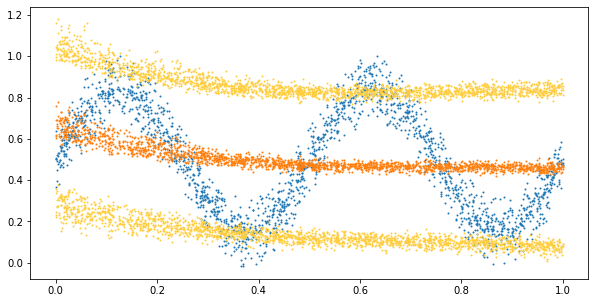

In [10]:
predictive = Predictive(model, guide=guide, num_samples=500)
#x_test = torch.linspace(-0.5, 1, 3000)


preds = predictive(i_val)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(i_val[:,0], o_val, 'o', markersize=1)
ax.plot(i_val[:,0], y_pred, 'o', markersize=1)
ax.plot(i_val[:,0], y_pred - y_std, 'o', markersize=1, color='#ffcd3c')
ax.plot(i_val[:,0], y_pred + y_std, 'o', markersize=1, color='#ffcd3c')

#ax.fill_between(x_val[:,0], y_pred - y_std, y_pred + y_std,alpha=0.5, color='#ffcd3c');